In [1]:
import bs4 as bs
import datetime as dt
import os
import pandas_datareader.data as web
import pickle
import requests
import pandas as pd
import dash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
import requests
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from sklearn.preprocessing import MinMaxScaler
import fix_yahoo_finance as yf
from pandas.tseries.offsets import BDay
from statsmodels.tsa.arima_model import ARIMA
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import deque
import random
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from statsmodels.tsa.stattools import adfuller
startdate="2017-11-22"
enddate="2018-11-22"
from pandas_datareader import data as pdr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from numpy import newaxis
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tensorflow.keras.layers import TimeDistributed

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [2]:
dow = ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'WBA', 'DIS','^DJI']

main_df = pd.DataFrame()
for ratio in dow:  # begin iteration

    dataset = f'/Users/Herdt/Desktop/python/stock_data/stock_history/{ratio}.csv'  # get the full path to the file.
    df = pd.read_csv(dataset)  # read in specific file

    # rename volume and close to include the ticker so we can still which close/volume is which:
    df.rename(columns={"volume": f"{ratio}_volume","open": f"{ratio}_open", "close": f"{ratio}_close", "high": f"{ratio}_high", "low": f"{ratio}_low", "adjclose": f"{ratio}_adjclose"}, inplace=True)

    df.set_index('date', inplace=True)
    #df.index = pd.to_datetime(df.index)
     # set time as index so we can join them on this shared time
    #df = df[[f"{ratio}_close", f"{ratio}_volume"]]  # ignore the other columns besides price and volume
    df.drop(f"{ratio}_open",1)
    df.drop(f"{ratio}_high",1)
    df.drop(f"{ratio}_low",1)
    df.drop(f"{ratio}_close",1)
    if len(main_df)==0:  # if the dataframe is empty
        main_df = df  # then it's just the current df
    else:  # otherwise, join this data to the main one
        main_df = main_df.join(df)
main_df = main_df.iloc[:2003]
main_df.dropna(inplace=True)
#main_df = main_df.pct_change()
main_df.dropna(inplace=True)
print(main_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2003 entries, 2019-04-18 to 2011-05-04
Columns: 180 entries, MMM_volume to ^DJI_volume
dtypes: float64(167), int64(13)
memory usage: 2.8+ MB
None


In [3]:
print(main_df.head())

            MMM_volume    MMM_open   MMM_close    MMM_high     MMM_low  \
date                                                                     
2019-04-18     1780100  217.979996  218.880005  219.669998  217.619995   
2019-04-17     1977600  217.630005  217.639999  219.330002  217.179993   
2019-04-16     1549600  216.589996  216.899994  217.669998  215.479996   
2019-04-15     1483300  216.839996  215.830002  217.360001  214.899994   
2019-04-12     1922400  215.100006  217.419998  217.490005  214.350006   

            MMM_adjclose  AXP_volume    AXP_open   AXP_close    AXP_high  ...  \
date                                                                      ...   
2019-04-18    218.880005   6186800.0  112.250000  113.669998  114.139999  ...   
2019-04-17    217.639999   3799900.0  112.309998  111.760002  112.500000  ...   
2019-04-16    216.899994   2523400.0  111.089996  111.879997  112.029999  ...   
2019-04-15    215.830002   2285000.0  110.919998  110.529999  110.970001  ..

In [4]:
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "AAPL_adjclose"


main_df['future'] = main_df[f'{RATIO_TO_PREDICT}'].shift(-FUTURE_PERIOD_PREDICT)
#main_df['target'] = list(map(classify, main_df[f'{RATIO_TO_PREDICT}'], main_df['future']))
main_df = main_df.pct_change()
main_df.dropna(inplace=True)

df_test = main_df.iloc[:50].values
df_train = main_df.iloc[50:].values

In [5]:
train_X, train_y = df_train[:, :-1], df_train[:, -1]
test_X, test_y = df_test[:, :-1], df_test[:, -1]
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(1952, 180)
(1952,)
(50, 180)
(50,)


In [6]:
x_scaler = preprocessing.StandardScaler()
train_X = x_scaler.fit_transform(train_X)
test_X = x_scaler.transform(test_X)

y_scaler = preprocessing.StandardScaler()
train_y= y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))



train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1952, 1, 180) (1952, 1) (50, 1, 180) (50, 1)


Train on 1952 samples, validate on 50 samples
Epoch 1/10
 - 8s - loss: 0.8070 - val_loss: 0.2156
Epoch 2/10
 - 3s - loss: 0.5989 - val_loss: 0.1816
Epoch 3/10
 - 2s - loss: 0.5195 - val_loss: 0.1800
Epoch 4/10
 - 3s - loss: 0.4759 - val_loss: 0.1996
Epoch 5/10
 - 3s - loss: 0.4514 - val_loss: 0.2004
Epoch 6/10
 - 2s - loss: 0.4331 - val_loss: 0.2132
Epoch 7/10
 - 3s - loss: 0.4228 - val_loss: 0.1905
Epoch 8/10
 - 3s - loss: 0.4013 - val_loss: 0.1672
Epoch 9/10
 - 2s - loss: 0.3810 - val_loss: 0.1673
Epoch 10/10
 - 2s - loss: 0.3720 - val_loss: 0.1582
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               447488    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)         

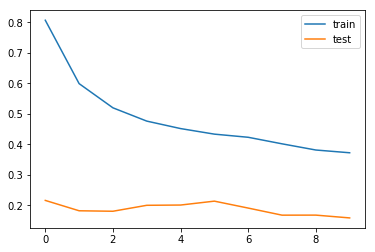

(50, 1)


In [7]:
# design network
model = Sequential()
model.add(LSTM(256 ,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1, activation='tanh'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='mse', optimizer=opt)
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.summary()
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
predictions = y_scaler.inverse_transform(yhat)
print(yhat.shape)
test_y_scaled = y_scaler.inverse_transform(test_y)

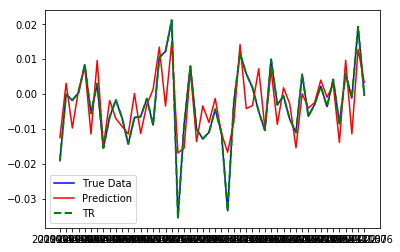

In [8]:
fig = plt.figure(facecolor='white') 
plt.plot(test_y_scaled, label='True Data',color='blue') 
plt.plot(predictions, label='Prediction',color='red')
plt.plot(main_df['future'].iloc[:50], label='TR',color='green', linestyle='dashed',linewidth=2)
plt.legend() 
plt.show()